In [1]:
from scipy.integrate import simps, dblquad
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
import numpy as np

from load import load_density

Определяем сетку и значения pdf

In [3]:
x_grid = np.linspace(-10, 10, 100)
y_grid = np.linspace(-10, 10, 100)

densties = np.array(load_density("out10.txt"))

pdf_values = densties.reshape((100, 100))

Строим график изначальной pdf

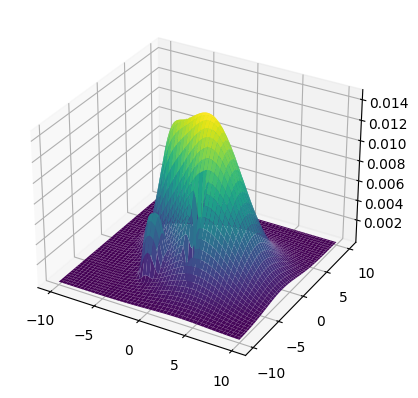

In [4]:
def plot_3d_surface(x_grid, y_grid, values):
    X, Y = np.meshgrid(x_grid, y_grid)
    Z = values

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis')

    plt.show()

plot_3d_surface(x_grid, y_grid, pdf_values)

Интегрируем значения PDF по y, чтобы получить CDF по x

In [22]:
cdf_x = np.array([simps(pdf_values[:, yi], y_grid) for yi in range(len(x_grid))])
cdf_x = np.cumsum(cdf_x)
cdf_x.shape

(100,)

In [5]:
cdf_x = np.array([simps(pdf_values[:, yi], y_grid) for yi in range(len(x_grid))])
cdf_x = np.cumsum(cdf_x)
cdf_x /= cdf_x[-1]

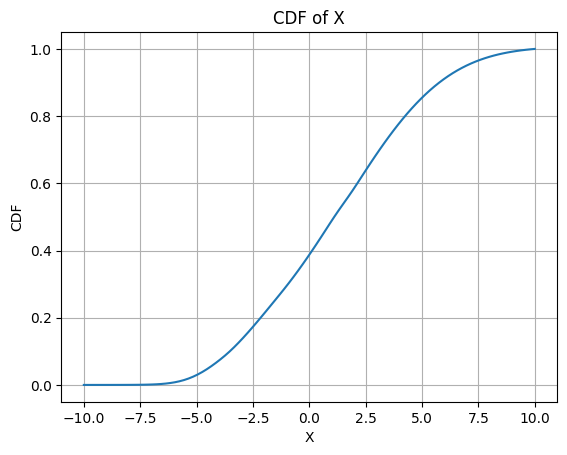

In [6]:
plt.plot(x_grid, cdf_x)
plt.xlabel('X')
plt.ylabel('CDF')
plt.title('CDF of X')
plt.grid(True)
plt.show()

Создаем обратную функцию CDFx

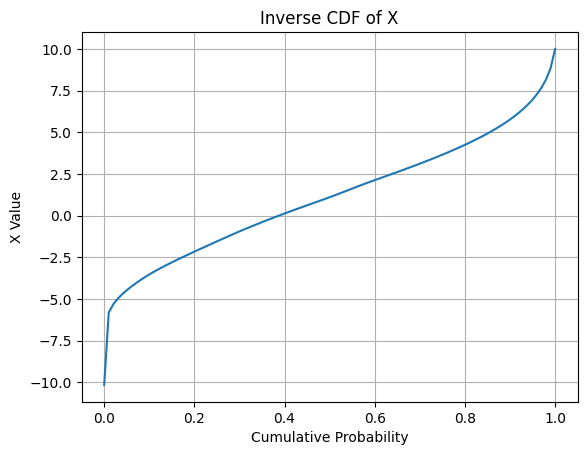

In [8]:
inverse_cdf_x = interp1d(cdf_x, x_grid, kind='linear', fill_value='extrapolate')

u_values = np.linspace(0, 1, 100)
x_values_from_inverse_cdf = inverse_cdf_x(u_values)

plt.plot(u_values, x_values_from_inverse_cdf)
plt.xlabel('Cumulative Probability')
plt.ylabel('X Value')
plt.title('Inverse CDF of X')
plt.grid(True)
plt.show()

Генерируем точки

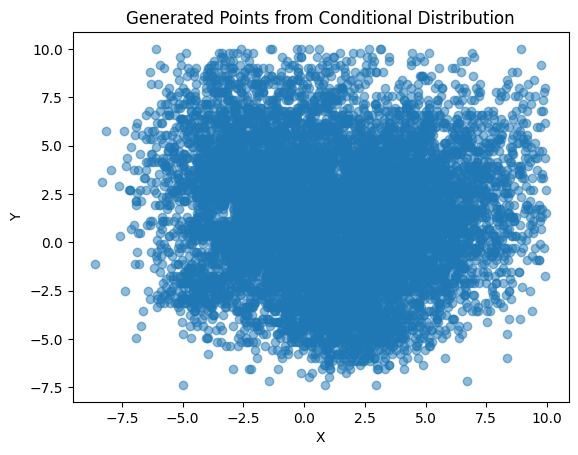

In [10]:
num_samples = 10000  # Количество генерируемых точек
random_u_values = np.random.uniform(0, 1, num_samples)  # Равномерно распределенные случайные числа
generated_x_values = inverse_cdf_x(random_u_values)  # Генерация X с использованием обратной CDF

# Генерация соответствующих значений Y для каждого сгенерированного X
generated_y_values = []

for x in generated_x_values:
    # Вычисление условной плотности вероятности Y при данном X
    conditional_pdf_y = pdf_values[np.argmin(np.abs(x_grid - x)), :]  # Выбор соответствующего среза PDF
    conditional_pdf_y /= np.sum(conditional_pdf_y)  # Нормализация условной плотности

    # Создание CDF из условной плотности вероятности Y
    conditional_cdf_y = np.cumsum(conditional_pdf_y)

    # Генерация Y с использованием обратного преобразования
    random_u = np.random.uniform(0, 1)
    y = y_grid[np.searchsorted(conditional_cdf_y, random_u)]
    generated_y_values.append(y)

# Визуализация сгенерированных точек
plt.scatter(generated_x_values, generated_y_values, alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Generated Points from Conditional Distribution')
plt.show()

Строим на их основе гистограмму

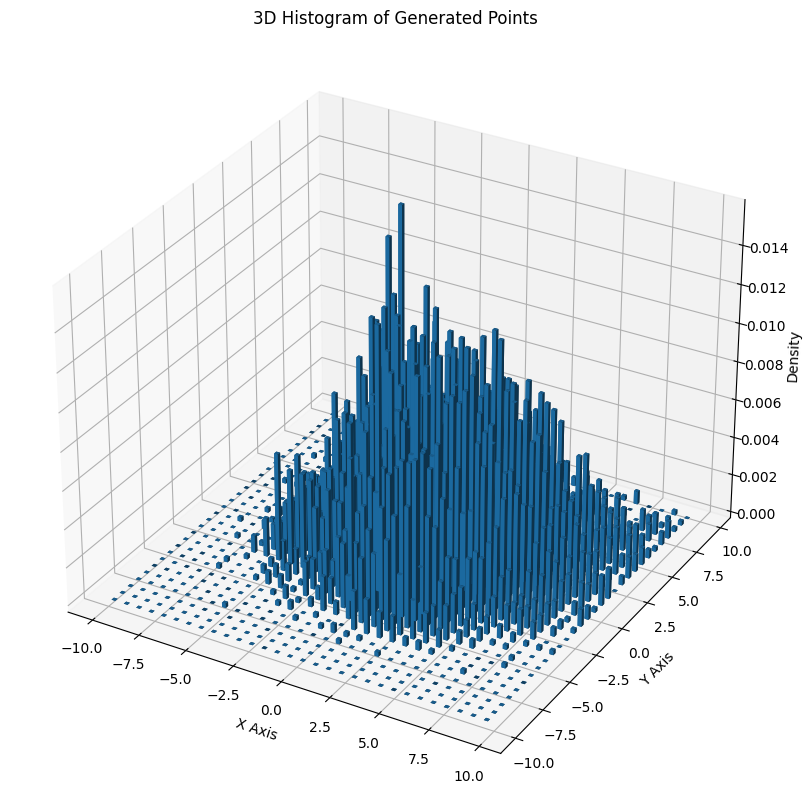

In [11]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Вычисление гистограммы для сгенерированных точек
hist_generated, xedges_generated, yedges_generated = np.histogram2d(generated_x_values, generated_y_values, bins=30, range=[[-10, 10], [-10, 10]], density=True)

# Подготовка данных для построения 3D гистограммы
xpos_generated, ypos_generated = np.meshgrid(xedges_generated[:-1] + 0.1, yedges_generated[:-1] + 0.1, indexing="ij")
xpos_generated = xpos_generated.ravel()
ypos_generated = ypos_generated.ravel()
zpos_generated = 0

# Размеры каждого столбика гистограммы
dx_generated = dy_generated = 0.2 * np.ones_like(zpos_generated)
dz_generated = hist_generated.ravel()

# Построение 3D гистограммы
ax.bar3d(xpos_generated, ypos_generated, zpos_generated, dx_generated, dy_generated, dz_generated, zsort='average')

# Установка меток осей
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Density')

plt.title('3D Histogram of Generated Points')
plt.show()